In [1]:
import torch
import matplotlib.pyplot as plt
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')

import json

import numpy as np

from datasets import load_dataset, load_metric

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig

from peft import LoraConfig, get_peft_model, TaskType, replace_lora_weights_loftq, prepare_model_for_kbit_training

In [2]:
# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# help functions
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")
    
    
def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data   

In [4]:
# Load IMDB dataset
imdb = load_dataset("imdb")
print("Dataset structure:")
print(imdb)

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [5]:
imdb.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [6]:
print("\nSample from the training set:")
print(imdb['train'][0])


Sample from the training set:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and n

In [7]:
train_labels = imdb['train']['label']
unique_labels = set(train_labels)
print("\nUnique labels in the dataset (class information):")
print(unique_labels)


Unique labels in the dataset (class information):
{0, 1}


In [8]:
class_names = {0: "negative", 1: "positive"}

In [9]:
train_dataset = imdb["train"].shuffle(seed=42)
test_dataset = imdb["test"].shuffle(seed=42)
print(f"No. of training sample: {len(train_dataset)}")
print(f"No. of testing sample: {len(test_dataset)}")

No. of training sample: 25000
No. of testing sample: 25000


In [10]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
my_tokens=tokenizer(imdb['train'][0]['text'])

# Print the tokenized input IDs
#print("Input IDs:", my_tokens['input_ids'])

# Print the attention mask
#print("Attention Mask:", my_tokens['attention_mask'])

# If token_type_ids is present, print it
if 'token_type_ids' in my_tokens:
    print("Token Type IDs:", my_tokens['token_type_ids'])
#my_tokens

In [11]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

In [12]:
#print(tokenized_train[0])

In [13]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy", trust_remote_code=True)

  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

   return {"accuracy": accuracy}

In [14]:
# Configure BitsAndBytes
config_bnb = BitsAndBytesConfig(
    load_in_4bit=True, # quantize the model to 4-bits when you load it
    bnb_4bit_quant_type="nf4", # use a special 4-bit data type for weights initialized from a normal distribution
    bnb_4bit_use_double_quant=True, # nested quantization scheme to quantize the already quantized weights
    bnb_4bit_compute_dtype=torch.bfloat16, # use bfloat16 for faster computation
    #llm_int8_skip_modules=["classifier", "pre_classifier"] #  Don't convert the "classifier" and "pre_classifier" layers to 8-bit
)

In [15]:
# Load a quantized version of a pretrained model
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = dict((v,k) for k,v in id2label.items())
model_lora = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased",
                                                                 id2label=id2label,
                                                                 label2id=label2id,
                                                                 num_labels=2,
                                                                 #quantization_config=config_bnb,
                                                                 #low_cpu_mem_usage=True
                                                                )


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Specify the task type as sequence classification
    r=8,  # Rank of the low-rank matrices
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,  # Dropout rate  
    target_modules=['q_lin','k_lin','v_lin'] # which modules
)

peft_model_lora = get_peft_model(model_lora, lora_config)
print(peft_model_lora)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): MultiHeadSelfAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768

In [17]:
peft_model_lora.print_trainable_parameters()

trainable params: 813,314 || all params: 67,768,324 || trainable%: 1.2001


In [18]:
training_args = TrainingArguments(
    output_dir="./results_lora",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    weight_decay=0.01
)

In [19]:
trainer_lora = Trainer(
    model=peft_model_lora,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)


trainer_lora.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.291900,0.261912,0.892640
2,0.257600,0.236248,0.903480
3,0.241100,0.239222,0.903440
4,0.242300,0.221895,0.912240
5,0.225300,0.221992,0.913640
6,0.220000,0.218181,0.914320
7,0.216500,0.218278,0.915520
8,0.226400,0.218418,0.915640
9,0.223200,0.215369,0.915560
10,0.217500,0.216122,0.915760


TrainOutput(global_step=15630, training_loss=0.24208555898831124, metrics={'train_runtime': 4003.1816, 'train_samples_per_second': 62.45, 'train_steps_per_second': 3.904, 'total_flos': 3.3741474816e+16, 'train_loss': 0.24208555898831124, 'epoch': 10.0})

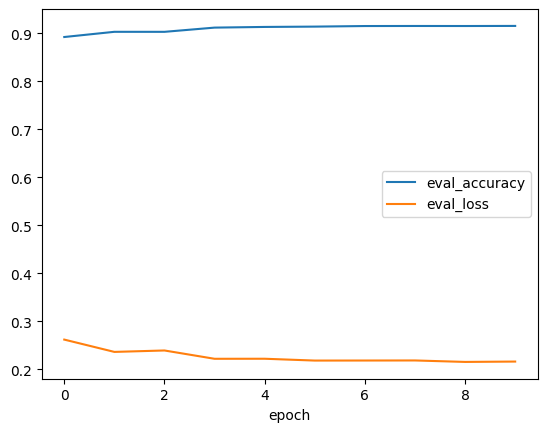

In [20]:
trainer_lora.save_model("./lora_final_model")
log_history_lora = trainer_lora.state.log_history
get_metric_lora = lambda metric, log_history_lora: [log[metric] for log in log_history_lora if metric in log]
eval_accuracy_lora=get_metric_lora('eval_accuracy',log_history_lora)
eval_loss_lora=get_metric_lora('eval_loss',log_history_lora)
plt.plot(eval_accuracy_lora,label='eval_accuracy')
plt.plot(eval_loss_lora,label='eval_loss')
plt.xlabel("epoch")
plt.legend()